## Imports

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import os
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

## Read in all audio files

In [2]:
audio_path_dir = 'data/audio/'

# Read in all the audio files
xs = []
fileNames = []
sr = 0
for filename in os.listdir(audio_path_dir):
    if filename.endswith(".wav"):
        x, sr = librosa.load(audio_path_dir + filename)
        xs.append(x)
        fileNames.append(filename)



## Find a way to find only the portion of the audio that contains the unique knock

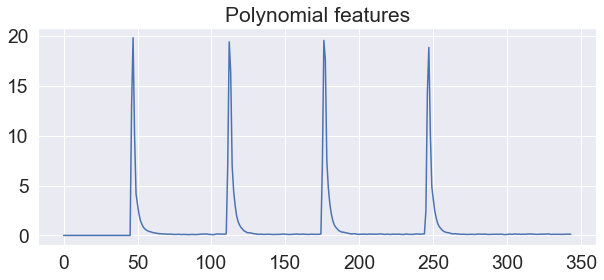

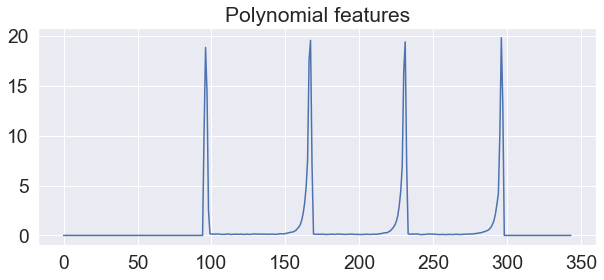

46
249


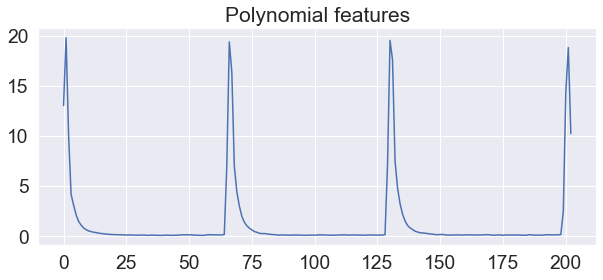

In [242]:
poly_features=librosa.feature.poly_features(xs[0]) #order 1 by default
features = poly_features[1]

# get first index where max(y) * 0.25 > y
first_above_quarter = np.argmax(features > np.max(features) * 0.25)

features[:first_above_quarter] = 0

plt.figure(figsize=(10, 4))
plt.plot(features)
plt.title('Polynomial features')
plt.show()


# reverse the array
features_reverse = features[::-1]

first_above_quarter_reverse = np.argmax(features_reverse > np.max(features_reverse) * 0.25)
features_reverse[:first_above_quarter_reverse] = 0

plt.figure(figsize=(10, 4))
plt.plot(features_reverse)
plt.title('Polynomial features')
plt.show()

first_zero = np.argmax(features != 0)
last_zero = np.argmax(features_reverse != 0)

print(first_zero)
print(len(features_reverse) - last_zero)

plt.figure(figsize=(10, 4))
plt.plot(features[first_zero:len(features_reverse) - last_zero])
plt.title('Polynomial features')
plt.show()

## Add only the slices with the unique knock to the dataframe

In [4]:
def get_knocks_poly_features(x):
    poly_features=librosa.feature.poly_features(x)
    features = poly_features[1]

    # get first index where max(y) * 0.25 > y
    first_above_quarter = np.argmax(features > np.max(features) * 0.25)

    features[:first_above_quarter] = 0

    # reverse the array
    features_reverse = features[::-1]

    first_above_quarter_reverse = np.argmax(features_reverse > np.max(features_reverse) * 0.25)
    features_reverse[:first_above_quarter_reverse] = 0

    first_zero = np.argmax(features != 0)
    last_zero = np.argmax(features_reverse != 0)
    
    return features[first_zero:len(features_reverse) - last_zero]

# make df with all the features
df = pd.DataFrame(columns=['file_name', 'knocks'])
for i in range(len(xs)):
    df.loc[i] = [fileNames[i], get_knocks_poly_features(xs[i])]

df.head()

,file_name,knocks
0,lfdtxqbcan.wav,"[13.046886186483114, 19.81441091043968, 10.096..."
1,ijpnxmctdv.wav,"[6.12540256199405, 7.412019304225442, 3.187284..."
2,ocavchpcbv.wav,"[4.898165355788606, 5.457928803066374, 2.89512..."
3,jpjcecupwp.wav,"[4.510988228587638, 5.751287698033109, 2.27795..."
4,ltmfyyflem.wav,"[2.357071442274309, 6.902252425189348, 5.32594..."


In [5]:
# make column for number of slices in each audio file
df['num_slices'] = df['knocks'].apply(lambda x: len(x))
df.head()

,file_name,knocks,num_slices
0,lfdtxqbcan.wav,"[13.046886186483114, 19.81441091043968, 10.096...",203
1,ijpnxmctdv.wav,"[6.12540256199405, 7.412019304225442, 3.187284...",178
2,ocavchpcbv.wav,"[4.898165355788606, 5.457928803066374, 2.89512...",81
3,jpjcecupwp.wav,"[4.510988228587638, 5.751287698033109, 2.27795...",76
4,ltmfyyflem.wav,"[2.357071442274309, 6.902252425189348, 5.32594...",147


In [6]:
df['num_slices'].max()

289

In [7]:
df['num_slices'].describe()

count    118.000000
mean     121.923729
std       50.181748
min       20.000000
25%       85.250000
50%      121.000000
75%      152.000000
max      289.000000
Name: num_slices, dtype: float64

## Function to add the slices of the knock to the dataframe

In [8]:
def prep_df(df, data):
    first_list = []
    second_list = []
    # loop through data and get the knocks for each file
    for i in range(len(data)):
        file_name_1 = data.loc[i]['filename1']
        file_name_2 = data.loc[i]['filename2']
        first = df[df['file_name'] == file_name_1]['knocks'].values[0]
        first_list.append(first)
        second = df[df['file_name'] == file_name_2]['knocks'].values[0]
        second_list.append(second)

    data['knocks1'] = first_list
    data['knocks2'] = second_list

    # pad knocks1 and knocks2 to be the same length
    data['knocks1'] = data['knocks1'].apply(lambda x: np.pad(x, (0, 300 - len(x)), 'constant'))
    data['knocks2'] = data['knocks2'].apply(lambda x: np.pad(x, (0, 300 - len(x)), 'constant'))

    # slices
    data['num_slices1'] = data['knocks1'].apply(lambda x: len(x))
    data['num_slices2'] = data['knocks2'].apply(lambda x: len(x))

    both_knocks = []
    for i in range(len(data)):
        both_knocks.append(np.append(data.loc[i]['knocks1'], data.loc[i]['knocks2']))

    data['both_knocks'] = both_knocks
    data['len_both_knocks'] = data['both_knocks'].apply(lambda x: len(x))
    
    return data

### Training Set

In [9]:
train = pd.read_csv("data/matchedData_300_0.3.csv")
train = train.drop(['Unnamed: 0'], axis=1)

train = prep_df(df, train)

train.head()

,filename1,filename2,label1,label2,match,knocks1,knocks2,num_slices1,num_slices2,both_knocks,len_both_knocks
0,rfjllsqsdk.wav,lnqsjqmyks.wav,207,207,True,"[3.1683177311546613, 7.508200346770938, 5.0665...","[6.899610052874308, 7.71701427717448, 3.224526...",300,300,"[3.1683177311546613, 7.508200346770938, 5.0665...",600
1,ycdinlhbms.wav,ycdinlhbms.wav,102,102,True,"[8.889170398893631, 17.6609467866882, 11.12785...","[8.889170398893631, 17.6609467866882, 11.12785...",300,300,"[8.889170398893631, 17.6609467866882, 11.12785...",600
2,rfjllsqsdk.wav,ctpfqrfjkm.wav,207,205,False,"[3.1683177311546613, 7.508200346770938, 5.0665...","[5.748266797804878, 7.480848160839301, 3.04271...",300,300,"[3.1683177311546613, 7.508200346770938, 5.0665...",600
3,fsohitjzej.wav,zjhfdatcqf.wav,206,208,False,"[3.5598844086672763, 4.335621176007653, 1.9318...","[4.290104964461244, 7.164355202819514, 3.54867...",300,300,"[3.5598844086672763, 4.335621176007653, 1.9318...",600
4,ixkhocbexb.wav,jlzswxwpsr.wav,211,216,False,"[2.4471693024105834, 7.653789219198792, 6.1626...","[5.6141202155947285, 8.263767621816063, 4.1058...",300,300,"[2.4471693024105834, 7.653789219198792, 6.1626...",600


### Validation Set

In [10]:
validation = pd.read_csv("data/validationData_100_0.3.csv")
validation = validation.drop(['Unnamed: 0'], axis=1)

validation = prep_df(df, validation)

validation.head()

,filename1,filename2,label1,label2,match,knocks1,knocks2,num_slices1,num_slices2,both_knocks,len_both_knocks
0,sdprvpqeqb.wav,sdprvpqeqb.wav,100,100,True,"[14.94531068006416, 19.907083309708483, 9.5530...","[14.94531068006416, 19.907083309708483, 9.5530...",300,300,"[14.94531068006416, 19.907083309708483, 9.5530...",600
1,jpjcecupwp.wav,iiuanaofgh.wav,4,4,True,"[4.510988228587638, 5.751287698033109, 2.27795...","[7.387259025892517, 9.075441080439905, 3.85901...",300,300,"[4.510988228587638, 5.751287698033109, 2.27795...",600
2,oagvqxyqxz.wav,tkaorzfyzc.wav,1,1,True,"[4.687125005412286, 6.837975713646822, 3.20446...","[5.1500454923729615, 6.471109295703672, 2.7018...",300,300,"[4.687125005412286, 6.837975713646822, 3.20446...",600
3,iiuanaofgh.wav,jpjcecupwp.wav,4,4,True,"[7.387259025892517, 9.075441080439905, 3.85901...","[4.510988228587638, 5.751287698033109, 2.27795...",300,300,"[7.387259025892517, 9.075441080439905, 3.85901...",600
4,uqvsgllfeq.wav,oagvqxyqxz.wav,1,1,True,"[5.790741388762458, 6.98969569585268, 3.063620...","[4.687125005412286, 6.837975713646822, 3.20446...",300,300,"[5.790741388762458, 6.98969569585268, 3.063620...",600


# Neural Network to classify the knock

In [315]:
dropout_rate = 0.1

model = Sequential()
model.add(Dense(300, activation='relu', input_dim=600))
model.add(Dropout(0.5))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(150, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.fit(np.array(train['both_knocks'].values.tolist()), np.array(train['match'].values.tolist()), epochs=100)

Epoch 1/100
32/32 [==============================] - 5s 10ms/step - loss: 0.6903 - accuracy: 0.6420
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6019 - accuracy: 0.6970
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.5615 - accuracy: 0.7210
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.5078 - accuracy: 0.7400
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.4353 - accuracy: 0.7760
Epoch 6/100
32/32 [==============================] - 0s 10ms/step - loss: 0.3156 - accuracy: 0.8630
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2418 - accuracy: 0.8940
Epoch 8/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1955 - accuracy: 0.9280
Epoch 9/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1855 - accuracy: 0.9250
Epoch 10/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1603 - accuracy: 0.9520
Epoch 1

In [316]:
# save the history of the model
history = model.history.history

print(history.keys())

dict_keys(['loss', 'accuracy'])


### Plot the accuracy

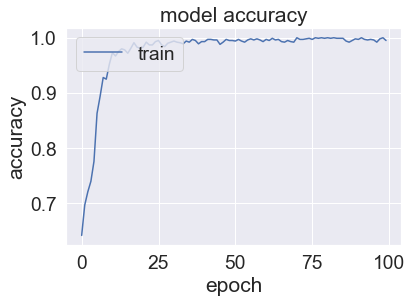

In [317]:
plt.plot(model.history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


### Test the validation set

In [318]:
model.evaluate(np.array(validation['both_knocks'].values.tolist()), np.array(validation['match'].values.tolist()))

4/4 [==============================] - 1s 35ms/step - loss: 0.6266 - accuracy: 0.8500


[0.6266200542449951, 0.8500000238418579]

### Find the best threshold using f1 score

In [319]:
best_threshold = 0
best_score = 0
for threshold in np.arange(0.1, 0.9, 0.01):
    y_pred = model.predict(np.array(validation['both_knocks'].values.tolist()))
    y_pred = (y_pred > threshold)
    score = f1_score(np.array(validation['match'].values.tolist()), y_pred)
    if score > best_score:
        best_threshold = threshold
        best_score = score
        print('New best threshold: ', best_threshold)
        print('New best score: ', best_score)

New best threshold:  0.1
New best score:  0.7924528301886793


### Create a confusion matrix and plot it

In [320]:
y_pred = model.predict(np.array(validation['both_knocks'].values.tolist()))
y_pred = (y_pred > .5)

cm = confusion_matrix(np.array(validation['match'].values.tolist()), y_pred)

print(cm)
print()

print('True Negatives: ', cm[0][0])
print('False Positives: ', cm[0][1])
print('False Negatives: ', cm[1][0])
print('True Positives: ', cm[1][1])

[[68  2]
 [13 17]]

True Negatives:  68
False Positives:  2
False Negatives:  13
True Positives:  17


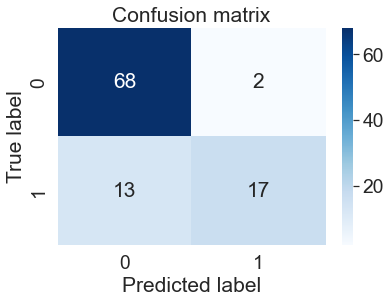

In [321]:
# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
sns.set(font_scale=1.75)


# add labels
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ROC Curve

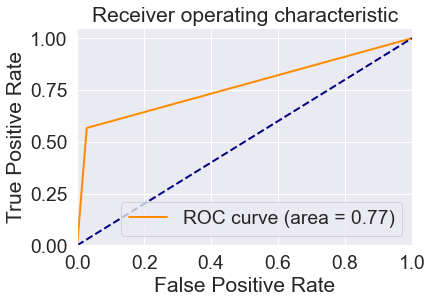

In [322]:
fpr, tpr, thresholds = roc_curve(np.array(validation['match'].values.tolist()), y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Save the model

In [323]:
# model.save('modelCheckpoints/knock_slices_model.h5')

In [324]:
# # change history to a dataframe
# history_df = pd.DataFrame(history)

# # save the history
# history_df.to_csv('modelCheckpoints/knock_slices_history.csv')

In [325]:
# save validation data
#validation.to_csv('modelCheckpoints/knock_slices_validation.csv')